In [71]:
import numpy as np
%config InlineBackend.figure_format='retina'
from getdist.mcsamples import loadMCSamples, MCSamples
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.collections import PatchCollection
import pylab as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
plt.rcParams['xtick.major.size'] = 5.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize'] = 20

import matplotlib as mpl
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.labelsize'] = 15

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

# Define the styles
styles = [
    dict(selector="th", props=[("font-size", "150%"), 
                               ("text-align", "center")]),
    dict(selector="td", props=[("font-size", "150%"), 
                               ("text-align", "center")]),
    dict(selector="th, td", props=[("border", "1px solid black")])
]

def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='r', edgecolor='r',alpha=0.2))
    labels.append(r"ACT DR6 lensing bandpowers")
    handles.append(Patch(facecolor='g', edgecolor='g',alpha=0.2))
    labels.append(r"Planck PR4 lensing bandpowers")
    handles.append(Patch(facecolor='dodgerblue', edgecolor='dodgerblue',alpha=0.2))
    labels.append(r"SPT 3G lensing bandpowers")
    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

GetDist Version: 1.4.6, Matplotlib version: 3.7.3


In [47]:
def top_hat_matrix(L, bin_edges):
    """
    Constructs a top-hat matrix B_ij where B_ij = 1 if L_j is within bin i, else 0.
    
    Parameters:
        L (array): The unbinned multipoles (e.g., full range of L values)
        bin_edges (array): The bin edges defining each bin [L_low, L_high]

    Returns:
        B (2D numpy array): A matrix where B[i, j] = 1 if L[j] is inside bin i.
    """
    num_bins = len(bin_edges) - 1
    num_L = len(L)
    
    B = np.zeros((num_bins, num_L))

    for i in range(num_bins):
        L_low, L_high = bin_edges[i], bin_edges[i+1]
        B[i, :] = (L >= L_low) & (L < L_high)  # Efficient vectorized condition
    
    return B

In [48]:
#fiducial theory predictions
clkk_fiducial=np.loadtxt('/gpfs/fs1/home/r/rbond/jiaqu/DR6lensing_backup/DR6lensing/full_mask/output/clkk_raw_plikHM_TTTEEE_lowl_lowE_dr6_accuracy.txt',unpack=True)
clkk_fiducial=clkk_fiducial[1][:5000]

In [49]:
#uber bandpower bin_edges
bin_edges=np.array([8,40,66,101,145,199,264,339,426,526,638,763,902,1100,1300, 1815,2362,3100])


In [52]:
uberkk =loadMCSamples("/home/r/rbond/jiaqu/ACTxDESI33/mcmc/likelihood/chains/qqq_new_binning_wide_test", no_cache = True, settings = {'ignore_rows': 0.3})




/home/r/rbond/jiaqu/ACTxDESI33/mcmc/likelihood/chains/qqq_new_binning_wide_test.3.txt
/home/r/rbond/jiaqu/ACTxDESI33/mcmc/likelihood/chains/qqq_new_binning_wide_test.2.txt
/home/r/rbond/jiaqu/ACTxDESI33/mcmc/likelihood/chains/qqq_new_binning_wide_test.1.txt
/home/r/rbond/jiaqu/ACTxDESI33/mcmc/likelihood/chains/qqq_new_binning_wide_test.4.txt
Removed 0.3 as burn in


In [54]:
p = uberkk.getParams()
n_alpha = 17

# Extract the means for each alpha_i into a NumPy array
alpha_means = np.array([uberkk.mean(getattr(p, f"alpha_{i}")) for i in range(n_alpha)])
# Similarly, extract the standard deviations
alpha_stds = np.array([uberkk.std(getattr(p, f"alpha_{i}")) for i in range(n_alpha)])

print("Alpha Means:", alpha_means)
print("Alpha Standard Deviations:", alpha_stds)


Alpha Means: [0.98071003 1.11312197 1.05396745 0.95838336 0.95809618 0.98150233
 1.05762648 0.88869712 1.12313389 0.95271754 0.92811641 1.10785826
 1.36595586 1.2289175  1.02739829 0.66091642 1.09992885]
Alpha Standard Deviations: [0.08585918 0.06095597 0.0480499  0.04146969 0.04148416 0.04693553
 0.05881331 0.06864063 0.08192391 0.08444974 0.09822376 0.13695623
 0.14672114 0.17585106 0.28983694 0.48300837 0.68458086]


## ALENS fit

In [55]:
all_names = uberkk.getParamNames().list()

# Filter for those starting with 'alpha_'
alpha_names = [name for name in all_names if name.startswith("alpha_")]

# Sort them numerically (assuming names like 'alpha_0', 'alpha_1', etc.)
alpha_names = sorted(alpha_names, key=lambda x: int(x.split('_')[1]))

# Now extract the covariance matrix for these parameters
cov_matrix = uberkk.getCovMat()

print("Covariance matrix for alpha parameters:")
print(cov_matrix)
cov=cov_matrix.matrix

Covariance matrix for alpha parameters:


In [56]:

def snr(auto, cov):
    # Compute the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)
    
    # Compute the SNR using the formula: sqrt(auto.T @ inv_cov @ auto)
    snr_value = np.sqrt(np.dot(auto.T, np.dot(inv_cov, auto)))
    return snr_value


In [57]:
signal=np.ones(len(alpha_means))
A_bf=(np.transpose(signal)@np.linalg.inv(cov)@alpha_means)/(np.transpose(signal)@np.linalg.inv(cov)@signal)
print(f"Alens:")
print(A_bf)
print("error")
print(np.sqrt(1/(np.transpose(signal)@np.linalg.inv(cov)@signal)))

Alens:
1.0100296877749064
error
0.015989838778206325


In [59]:
1.0100296877749064/0.015989838778206325


63.166971336293074

In [60]:
B_matrix=top_hat_matrix(np.arange(3100), bin_edges)

In [61]:
fid=np.sum(B_matrix*clkk_fiducial[:3100],axis=0 )
fit=np.sum(B_matrix*alpha_means[:,None]*clkk_fiducial[:3100],axis=0 )
fit_u=np.sum(B_matrix*(alpha_means+alpha_stds)[:,None]*clkk_fiducial[:3100],axis=0 ) #upper error
fit_d=np.sum(B_matrix*(alpha_means-alpha_stds)[:,None]*clkk_fiducial[:3100],axis=0 ) #lower error

## make plots

In [62]:
from matplotlib.patches import Patch

plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 2

def makeErrorBoxes(xdata,ydata,xerror,yerror,ax,fc='r',ec='black',alpha=0.3,label=None):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye in zip(xdata,ydata,xerror.T,yerror.T):
        rect = Rectangle((xc-xe[0],yc-ye[0]),xe.sum(),ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes,facecolor=fc,alpha=alpha,edgecolor=ec)


    # Add collection to axes
    ax.add_collection(pc)
    

def get_bin_centers_and_widths(bin_edges):
    """
    Returns the bin centers and bin widths for a given array of bin edges.

    Parameters
    ----------
    bin_edges : array-like
        1D array of bin edges, length = N + 1.

    Returns
    -------
    bin_centers : numpy.ndarray
        The midpoint of each bin, length N.
    bin_widths : numpy.ndarray
        The width of each bin, length N.
    """
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    return bin_centers, bin_widths

centers, widths = get_bin_centers_and_widths(bin_edges)
print("Bin centers:", centers)
print("Bin widths:", widths)

Bin centers: [  24.    53.    83.5  123.   172.   231.5  301.5  382.5  476.   582.
  700.5  832.5 1001.  1200.  1557.5 2088.5 2731. ]
Bin widths: [ 32  26  35  44  54  65  75  87 100 112 125 139 198 200 515 547 738]


In [63]:
bmat=np.loadtxt('/home/r/rbond/jiaqu/scratch/DR6/uber_matrix_new.txt')
Lfit=bmat@np.arange(3100)
scaling_fit=(2/np.pi)*np.sqrt(Lfit)
yerror = np.array([bmat @ (fit - fit_d), bmat @ (fit_u - fit)])
uber_bandpower=(bmat @ fit)


In [64]:
scaling_fid=(2/np.pi)*np.sqrt(np.arange(len(fid)))


## act bandpower

In [28]:
act_color='#DC143C'

act=np.array([2.42998730e-07, 2.30417556e-07, 2.35393578e-07, 1.82200956e-07,
       1.36753029e-07, 1.00006870e-07, 7.57806073e-08, 6.16674925e-08,
       4.39141156e-08, 4.09108581e-08, 2.49262271e-08, 1.55812549e-08,
       1.51589054e-08, 1.43829024e-08, 9.05925117e-09, 8.34021076e-09,
       2.73756518e-09, 3.81840766e-09])

act_error=np.array([4.40528654e-08, 2.37125183e-08, 1.57328003e-08, 9.60120565e-09,
       6.80489953e-09, 5.35635794e-09, 4.69542737e-09, 4.76293843e-09,
       3.92905083e-09, 3.21649991e-09, 2.71631720e-09, 2.59452103e-09,
       2.19305060e-09, 1.83861369e-09, 1.71396071e-09, 1.68440558e-09,
       1.90900693e-09, 2.55426249e-09])

bin_centers=np.array([  14.5,   30.5,   53. ,   83.5,  123. ,  172. ,  231.5,  301.5,
        382.5,  476. ,  582. ,  700.5,  832.5, 1001. , 1200. , 1400. ,
       1600. , 1874. ])
factor=2/np.pi
scaling_a=np.sqrt(bin_centers)

act_bins=np.array([8,21,40,66,101,145,199,264,339,426,526,638,763,902,1100,1300,1500,1700,2048])
diff=np.diff(act_bins)

## PR4

In [31]:
diff_p=np.array([32,43,129-85,174-130,219-175,264-220,309-265,354-310,400-355])

planck_bins=np.array([ 28.07,  63.53, 106.23, 150.44, 195.14, 240.27, 285.8 , 331.42,
       377.28])
Clp=np.array([2.07566597e-07, 2.11023920e-07, 1.57965562e-07, 1.09056933e-07,
        8.68848289e-08, 7.16942859e-08, 6.89576446e-08, 5.83472296e-08,
        3.91282223e-08])
ep=np.array([1.79227861e-08, 9.13889303e-09, 6.40570742e-09, 5.67842872e-09,
        5.57475616e-09, 6.08055258e-09, 6.41199061e-09, 6.16537558e-09,
        6.14181364e-09])
scaling_p=(2/np.pi)*np.sqrt(planck_bins)


## SPT-3G


In [32]:
import numpy as np

data_str = """\
#   L, CL_kk, err_CL_kk          
   29.5    2.57795e-7  7.77572e-8
   52.0    2.34131e-7  4.01835e-8
   82.5    2.19017e-7  2.57455e-8
  115.073  1.12796e-7  1.96165e-8
  149.764  1.17795e-7  1.25793e-8
  194.913  1.08312e-7  8.25845e-9
  253.672  7.20364e-8  6.12916e-9
  330.146  4.82742e-8  4.55465e-9
  429.674  3.31759e-8  2.92916e-9
  559.206  2.51113e-8  2.08085e-9
  727.787  1.83417e-8  1.66878e-9
  947.191  1.44598e-8  1.52588e-9
 1232.74   1.00448e-8  1.43736e-9
 1604.36   4.81389e-9  1.48604e-9
 2088.03   2.0705e-9   1.52986e-9
 2717.5    2.33411e-9  1.40529e-9
"""

Ls = []
CL_kk = []
err_CL_kk = []

lines = data_str.strip().split('\n')
for line in lines:
    # Skip the header or incomplete lines
    if 'L,' in line:  # The header row
        continue
    parts = line.split()
    if len(parts) < 3:
        continue  # Skip lines that don't have at least 3 columns
    
    L_val = float(parts[0])
    c_ell = float(parts[1])
    err_c_ell = float(parts[2])
    
    Ls.append(L_val)
    CL_kk.append(c_ell)
    err_CL_kk.append(err_c_ell)

# Convert to NumPy arrays
Ls = np.array(Ls)
CL_kk = np.array(CL_kk)
err_CL_kk = np.array(err_CL_kk)
scaling_spt=(2/np.pi)*np.sqrt(Ls)

spt_bins=np.array([20.0,
   39.0,
   65.0,
  100.0,
  130.14660887,
  169.38139801,
  220.44414557,
  286.90057992,
  373.3913756,
  485.95621316,
  632.45553203,
  823.11942757,
 1071.26202195,
 1394.2111937,
 1814.51858912,
 2361.5344111,
 3073.4569534])
diff_spt=np.diff(spt_bins)

In [33]:
Ls

array([  29.5  ,   52.   ,   82.5  ,  115.073,  149.764,  194.913,
        253.672,  330.146,  429.674,  559.206,  727.787,  947.191,
       1232.74 , 1604.36 , 2088.03 , 2717.5  ])

In [34]:
def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='r', edgecolor='r',alpha=0.2))
    labels.append(r"ACT DR6")
    handles.append(Patch(facecolor='g', edgecolor='g',alpha=0.2))
    labels.append(r"Planck PR4")
    handles.append(Patch(facecolor='dodgerblue', edgecolor='dodgerblue',alpha=0.2))
    labels.append(r"SPT-3G")
    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

In [35]:
Lfit

array([  14.5,   30.5,   53. ,   83.5,  123. ,  172. ,  231.5,  301.5,
        382.5,  476. ,  582. ,  700.5,  832.5, 1001. , 1200. , 1557.5,
       2088.5, 2730.5])

In [36]:
yerror[0]

array([1.88567898e-07, 5.79315141e-08, 1.25390184e-08, 8.46888283e-09,
       5.95429229e-09, 4.46421800e-09, 3.73561630e-09, 3.44369437e-09,
       3.05197289e-09, 2.70519162e-09, 2.07839493e-09, 1.81293404e-09,
       1.94478736e-09, 1.56275922e-09, 1.42789162e-09, 1.50730256e-09,
       1.54400647e-09, 1.22259620e-09])

In [76]:
scaling_fit=np.array([ 3.1187872 ,  4.6346619 ,  5.81732545,  7.06045483,  8.34919004,
        9.68624881, 11.05410998, 12.45075945, 13.88940365, 15.35824585,
       16.84939039, 18.36843873, 20.14174817, 22.05315582, 25.12431042,
       29.09359325, 33.26604827])
uber_bandpower=np.array([2.00795222e-07, 2.30956545e-07, 1.86460233e-07, 1.33825466e-07,
       1.01063617e-07, 7.71459352e-08, 6.19722098e-08, 3.92298593e-08,
       3.68437388e-08, 2.33660572e-08, 1.72404516e-08, 1.57988344e-08,
       1.45719293e-08, 9.75507152e-09, 5.41465016e-09, 2.14271294e-09,
       2.30510738e-09])



array([2.00795222e-07, 2.30956545e-07, 1.86460233e-07, 1.33825466e-07,
       1.01063617e-07, 7.71459352e-08, 6.19722098e-08, 3.92298593e-08,
       3.68437388e-08, 2.33660572e-08, 1.72404516e-08, 1.57988344e-08,
       1.45719293e-08, 9.75507152e-09, 5.41465016e-09, 2.14271294e-09,
       2.30510738e-09])

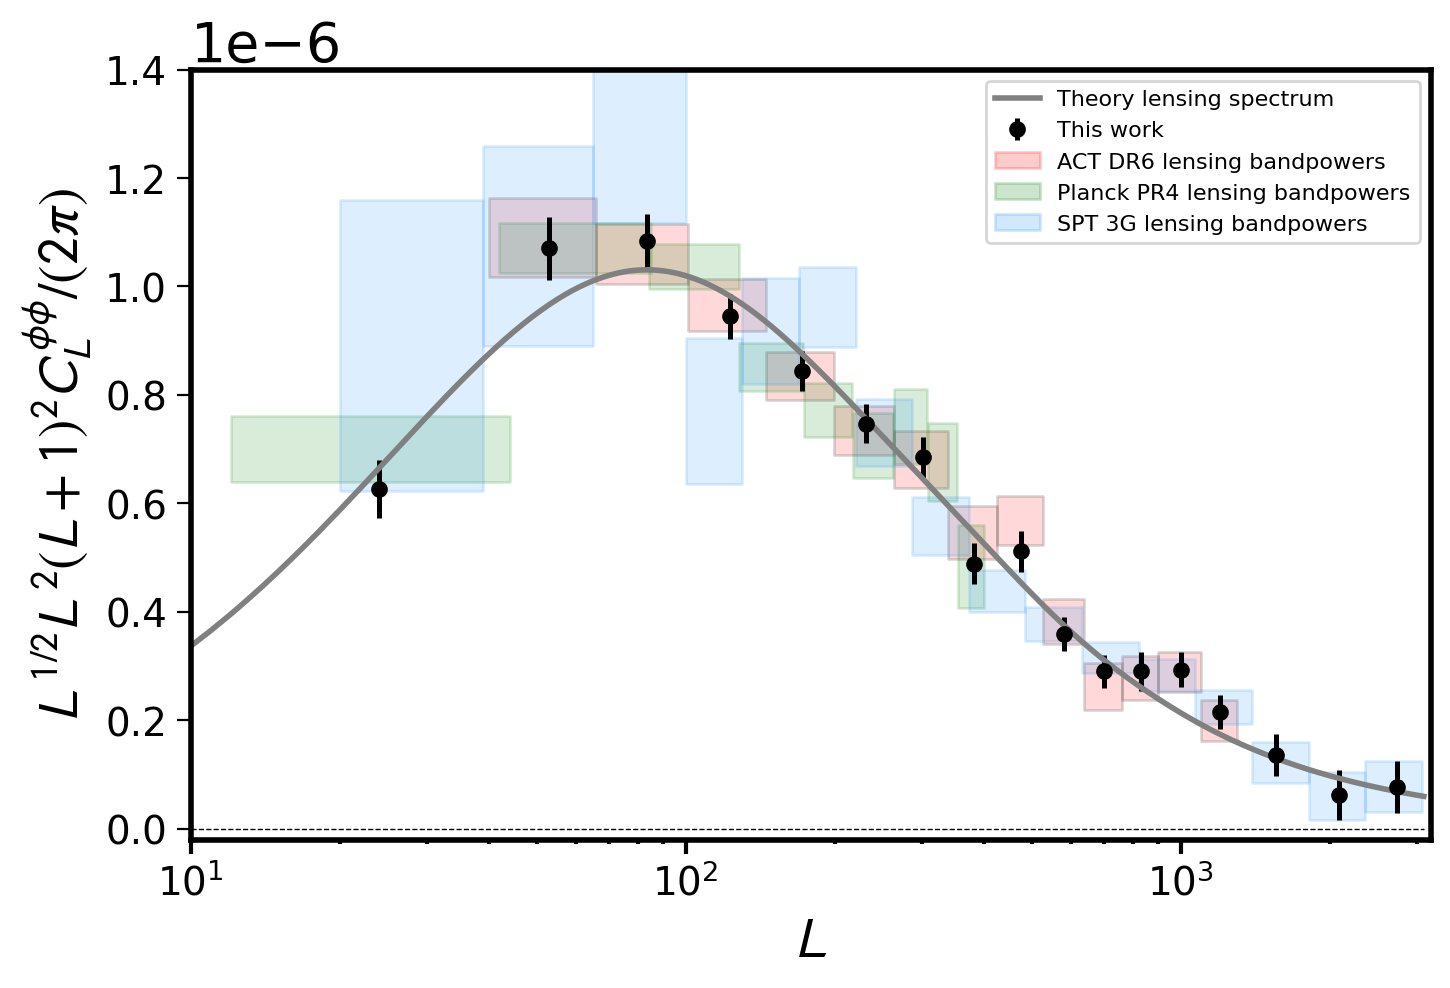

In [72]:
fig, ax = plt.subplots(figsize=(8, 5))

makeErrorBoxes(bin_centers[2:-3],act[2:-3]*factor*scaling_a[2:-3],np.array([diff[2:-3]/2,diff[2:-3]/2]),np.array([act_error[2:-3]*factor*scaling_a[2:-3],act_error[2:-3]*factor*scaling_a[2:-3]]),ax,fc='r',ec='black',alpha=0.15,label='ACT DR6 lensing bandpowers')

makeErrorBoxes(planck_bins,Clp*scaling_p,np.array([diff_p/2,diff_p/2]),np.array([ep*scaling_p,ep*scaling_p]),ax,fc='g',ec='g',alpha=0.15,label='$Planck$ NPIPE lensing bandpowers')

makeErrorBoxes(Ls,CL_kk*scaling_spt,np.array([diff_spt/2,diff_spt/2]),np.array([err_CL_kk*scaling_spt,err_CL_kk*scaling_spt]),ax,fc='dodgerblue',ec='dodgerblue',alpha=0.15,label='$SPT lensing bandpowers')


ax.errorbar(Lfit,scaling_fit*uber_bandpower,yerr=scaling_fit*yerror[0], color="black",fmt='o', mfc="black",elinewidth=1.8,capthick=0., ecolor="black", markersize=5 ,capsize=0,label='This work')
plt.semilogx(np.arange(3100),scaling_fid*fid, label='Theory lensing spectrum',linewidth=2,color='grey')

ax.set_ylabel("$L^{1/2}L^2(L+1)^2C^{\phi\phi}_L/(2\pi)$", fontsize=20)
ax.set_xlabel("$L$", fontsize=20)

ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(10,3200)
ax.set_ylim(-2e-8,1.4e-6)
ax.margins(0.1)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(20)  # or another smaller font size
ldg=ax.legend(prop={'size':8})
add_patch(ldg)

ax.hlines(0,10,3100,linestyle='--',color='k',linewidth=0.5)
plt.savefig('uber.pdf', bbox_inches="tight")

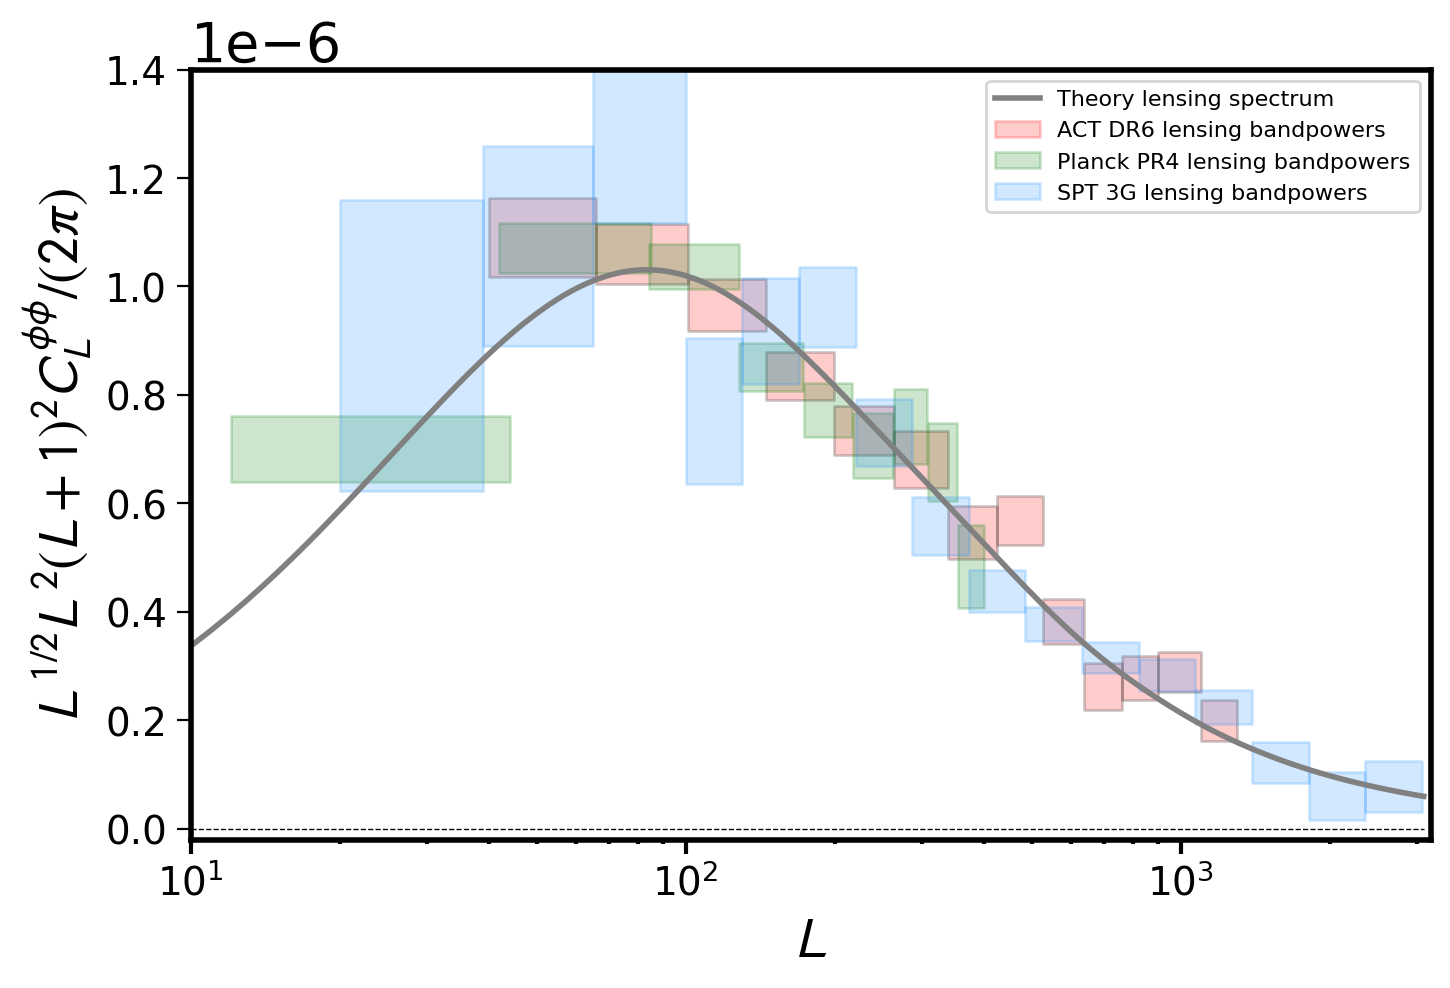

In [74]:
fig, ax = plt.subplots(figsize=(8, 5))

makeErrorBoxes(bin_centers[2:-3],act[2:-3]*factor*scaling_a[2:-3],np.array([diff[2:-3]/2,diff[2:-3]/2]),np.array([act_error[2:-3]*factor*scaling_a[2:-3],act_error[2:-3]*factor*scaling_a[2:-3]]),ax,fc='r',ec='black',alpha=0.2,label='ACT DR6 lensing bandpowers')

makeErrorBoxes(planck_bins,Clp*scaling_p,np.array([diff_p/2,diff_p/2]),np.array([ep*scaling_p,ep*scaling_p]),ax,fc='g',ec='g',alpha=0.2,label='$Planck$ NPIPE lensing bandpowers')

makeErrorBoxes(Ls,CL_kk*scaling_spt,np.array([diff_spt/2,diff_spt/2]),np.array([err_CL_kk*scaling_spt,err_CL_kk*scaling_spt]),ax,fc='dodgerblue',ec='dodgerblue',alpha=0.2,label='$SPT lensing bandpowers')


# ax.errorbar(Lfit,scaling_fit*uber_bandpower,yerr=scaling_fit*yerror[0], color="black",fmt='o', mfc="black",elinewidth=1.8,capthick=0., ecolor="black", markersize=5 ,capsize=0,label='This work')
plt.semilogx(np.arange(3100),scaling_fid*fid, label='Theory lensing spectrum',linewidth=2,color='grey')

ax.set_ylabel("$L^{1/2}L^2(L+1)^2C^{\phi\phi}_L/(2\pi)$", fontsize=20)
ax.set_xlabel("$L$", fontsize=20)

ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(10,3200)
ax.set_ylim(-2e-8,1.4e-6)
ax.margins(0.1)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(20)  # or another smaller font size
ldg=ax.legend(prop={'size':8})
add_patch(ldg)

ax.hlines(0,10,3100,linestyle='--',color='k',linewidth=0.5)
plt.savefig('uber1.pdf', bbox_inches="tight")

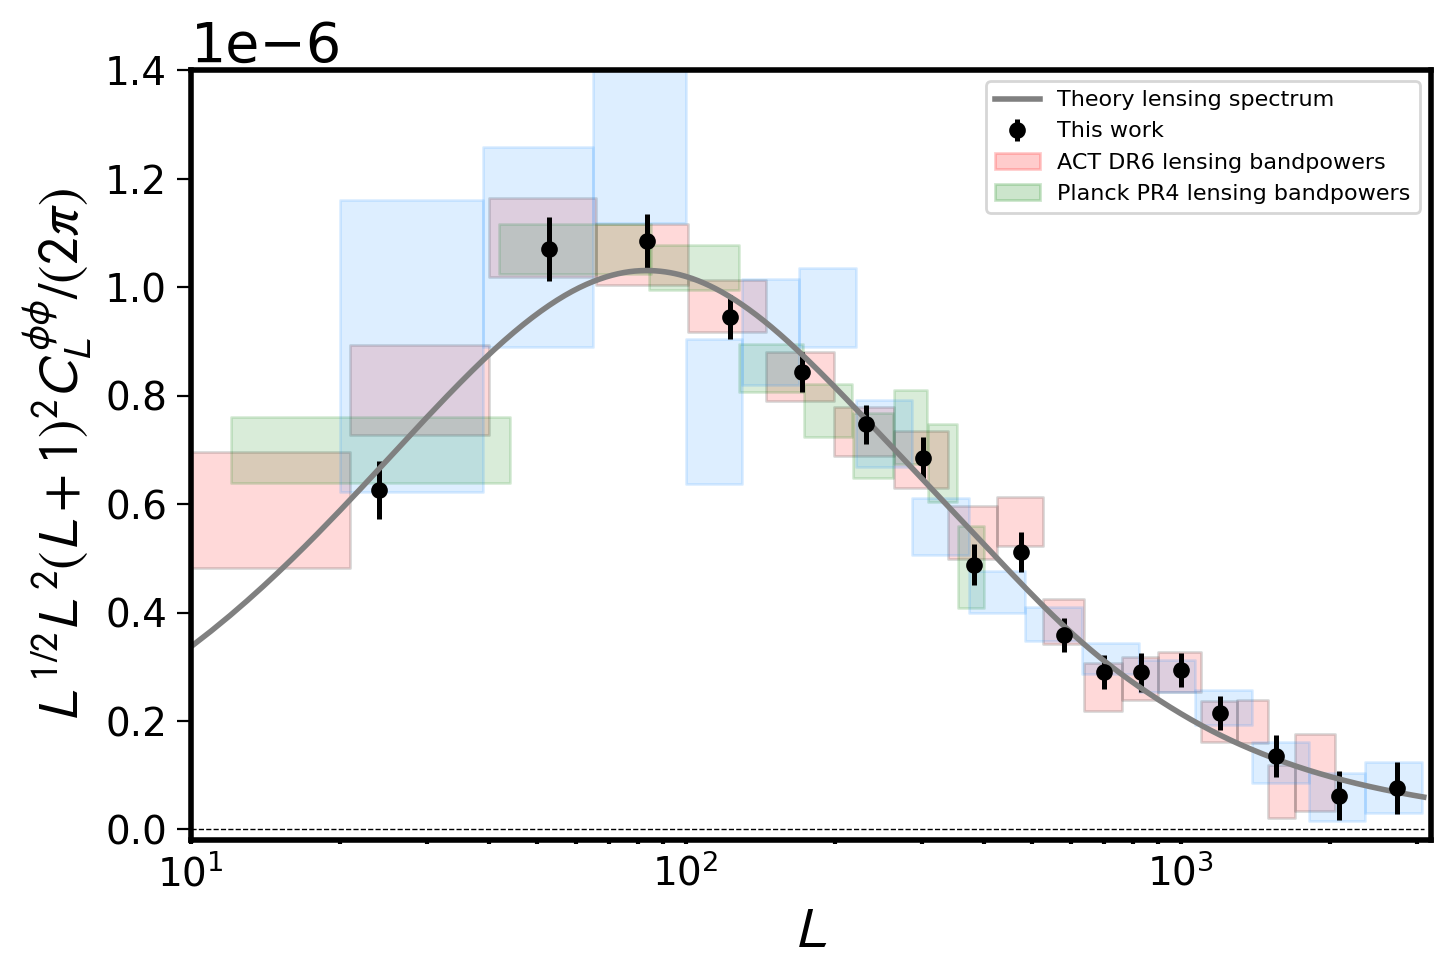

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))

makeErrorBoxes(bin_centers,act*factor*scaling_a,np.array([diff/2,diff/2]),np.array([act_error*factor*scaling_a,act_error*factor*scaling_a]),ax,fc='r',ec='black',alpha=0.15,label='ACT DR6 lensing bandpowers')

makeErrorBoxes(planck_bins,Clp*scaling_p,np.array([diff_p/2,diff_p/2]),np.array([ep*scaling_p,ep*scaling_p]),ax,fc='g',ec='g',alpha=0.15,label='$Planck$ NPIPE lensing bandpowers')

makeErrorBoxes(Ls,CL_kk*scaling_spt,np.array([diff_spt/2,diff_spt/2]),np.array([err_CL_kk*scaling_spt,err_CL_kk*scaling_spt]),ax,fc='dodgerblue',ec='dodgerblue',alpha=0.15,label='$SPT lensing bandpowers')


ax.errorbar(Lfit,scaling_fit*uber_bandpower,yerr=scaling_fit*yerror, color="black",fmt='o', mfc="black",elinewidth=1.8,capthick=0., ecolor="black", markersize=5 ,capsize=0,label='This work')
plt.semilogx(np.arange(3100),scaling_fid*fid, label='Theory lensing spectrum',linewidth=2,color='grey')

ax.set_ylabel("$L^{1/2}L^2(L+1)^2C^{\phi\phi}_L/(2\pi)$", fontsize=20)
ax.set_xlabel("$L$", fontsize=20)

ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(10,3200)
ax.set_ylim(-2e-8,1.4e-6)
ax.margins(0.1)

ax.tick_params(axis='both', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(20)  # or another smaller font size
ldg=ax.legend(prop={'size':8})
add_patch(ldg)

ax.hlines(0,10,3100,linestyle='--',color='k',linewidth=0.5)

plt.savefig('uber.pdf', bbox_inches="tight")

In [104]:
from getdist import plots, MCSamples


In [114]:
alpha_means

array([0.97718511, 0.98666943, 1.11150665, 1.05344984, 0.95937823,
       0.95802974, 0.98148064, 1.05654465, 0.88412117, 1.12474521,
       0.95667925, 0.93093827, 1.10941221, 1.31841518, 1.20592672,
       1.02422416, 0.89500343, 1.00859597])

In [116]:
alpha_stds

array([0.28883092, 0.12560243, 0.06155071, 0.04841878, 0.04198472,
       0.04127137, 0.04694202, 0.05848002, 0.06718713, 0.08181928,
       0.0838547 , 0.09666095, 0.13167869, 0.11176866, 0.15561853,
       0.23380193, 0.25724182, 0.27757696])

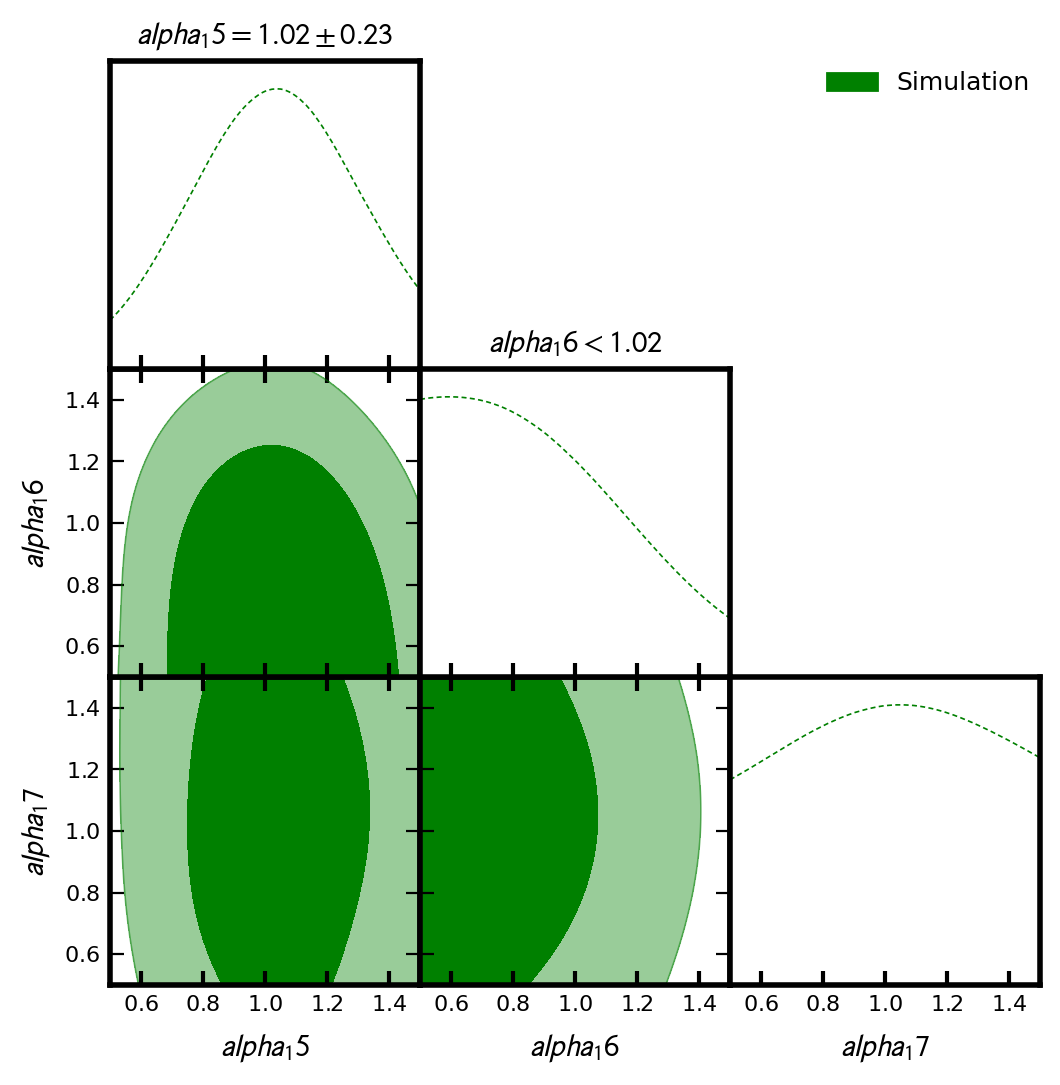

In [112]:
# Customized triangle plot
%matplotlib inline
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([uberkk], ['alpha_15',  'alpha_16','alpha_17'], 
    filled=True, 
    legend_labels=['Simulation', 'Simulation 2'], 
    legend_loc='upper right', 
    line_args=[{'ls':'--', 'color':'green'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['green','darkblue'],
    title_limit=1, # first title limit (for 1D plots) is 68% by default
    markers={'x2':0}, marker_args={'lw': 1})

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

# Now, call your function. Notice that we calculate the xerrors and yerrors arrays.
xerror = np.array([widths/2, widths/2])
yerror = np.array([bmat @ (fit - fit_d), bmat @ (fit_u - fit)])

makeErrorBoxes(centers, scaling_fit*(bmat @ fit), (xerror), scaling_fit*yerror, ax, fc='g',ec='g',alpha=0.6)
plt.semilogx(np.arange(3100),scaling_fid*fid, label='Theory lensing spectrum',color='k')
ax.errorbar(Lp,scaling_planck*Clp,yerr=scaling_planck*ep, color="darkorange",fmt='o', mfc="darkorange",capthick=0., ecolor="darkorange", markersize=3 ,capsize=0,label='Planck',alpha=0.8)
ax.errorbar(Ls,scaling_spt*CL_kk,yerr=scaling_spt*err_CL_kk, color="dodgerblue",fmt='o', mfc="dodgerblue",capthick=0., ecolor="dodgerblue", markersize=3 ,capsize=0,label='SPT')
ax.errorbar(bin_center,scaling_act*act,yerr=scaling_act*act_error, color=act_color,fmt='o', mfc=act_color,capthick=0., ecolor=act_color, markersize=3 ,capsize=0,label='ACT')
ax.tick_params(axis='y', labelsize=ticksize54)
ax.tick_params(axis='x', labelsize=ticksize54)
# Optionally, customize your plot further
ax.set_ylabel("$L^{1/2}L^2(L+1)^2C^{\phi\phi}_L/(2\pi)$", fontsize=20)
ax.set_xlabel("$L$", fontsize=20)

ax.set_xlim(10,3100)
ax.set_ylim(-2e-8,1.4e-6)
ax.yaxis.get_offset_text().set_fontsize(20)  # or another smaller font size

ax.hlines(0,10,3100,linestyle='--',color='k',linewidth=0.5)
ax.legend()
plt.show()


In [42]:
bmat=np.loadtxt('/home/r/rbond/jiaqu/scratch/DR6/uber_matrix_new.txt')


In [43]:
bmat@np.arange(3100)

array([  24. ,   53. ,   83.5,  123. ,  172. ,  231.5,  301.5,  382.5,
        476. ,  582. ,  700.5,  832.5, 1001. , 1200. , 1557.5, 2088.5,
       2730.5])

In [44]:
bin_edges=np.array([8,40,66,101,145,199,264,339,426,526,638,763,902,1100,1300,1815,2362,3100])


In [45]:
len(bin_edges)

18